In [1]:

from attorch.dataset import ListDataset
from blinkende_lichter.datatools import RandomFlip, TypeConversion 
from torchvision import transforms 
from torch.utils.data import DataLoader 
import numpy as np 
import torch

from PIL import Image
from argparse import ArgumentParser

from torch.optim import Adam
from torch.autograd import Variable

from blinkende_lichter.unet.network import UNet
from blinkende_lichter.unet.criterion import CrossEntropyLoss2d

from random import randint
import matplotlib.pyplot as plt
import random

In [2]:
transform = transforms.Compose([    
    RandomFlip(),    
    TypeConversion(np.float32, np.long) ]) 
dat = np.load('../datasets/data_interpolated.npz')

tr = dat['train']
vd = dat['validation']
for image in tr[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
    

for image in vd[1]:
    for h in range(len(image)):
        for w in range(len(image[0])):
            if(image[h][w]==0):
                image[h][w]=0
            else:
                image[h][w] = 1
               


            
            
train = ListDataset(*tr, transform=transform)

val = ListDataset(*vd) 
trainloader = DataLoader( train, shuffle=True, batch_size=1) 
for x, y in trainloader:
    print(x.size(), y.size())
images, labels = next(iter(trainloader))


torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 2, 512, 512]) torch.Size([1, 512, 512])


In [20]:
MAX_CHECKS = 50
best_score = 1000
checks = 0
NUM_CHANNELS = 2
NUM_CLASSES = 2


Net = UNet
model = Net(NUM_CLASSES)
model = model.cuda()

In [21]:
model.train()
weight = torch.ones(NUM_CLASSES)
weight[0] = 0
criterion = CrossEntropyLoss2d()
optimizer = Adam(model.parameters())
epoch_loss = []
val_epoch_loss = []
train_inputs = []
train_targets = []
train_outputs = []
val_inputs = []
val_targets = []
val_outputs = []
for epoch in range(1, 1001):
    for step, (images, labels) in enumerate(trainloader):
        images = images.cuda()
        labels = labels.cuda()
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_inputs.append(inputs.data.cpu().numpy())
        train_targets.append(targets.data.cpu().numpy())
        train_outputs.append(outputs.data.cpu().numpy())
        epoch_loss.append((loss.data[0]))
        

    model.eval()

    for i in range(len(val.data[0])):
        input = torch.FloatTensor(val.data[0][i]).cuda()
        target = Variable(torch.from_numpy(val.data[1][i])).cuda()
        output = model(Variable(input).unsqueeze(0))
        val_inputs.append(input.cpu().numpy())
        val_targets.append(target.data.cpu().numpy())
        val_outputs.append(output.data.cpu().numpy())
        val_loss = criterion(output, target.unsqueeze(0))
        val_epoch_loss.append(val_loss.data[0])

print("Training and validation complete.")

Training and validation complete.


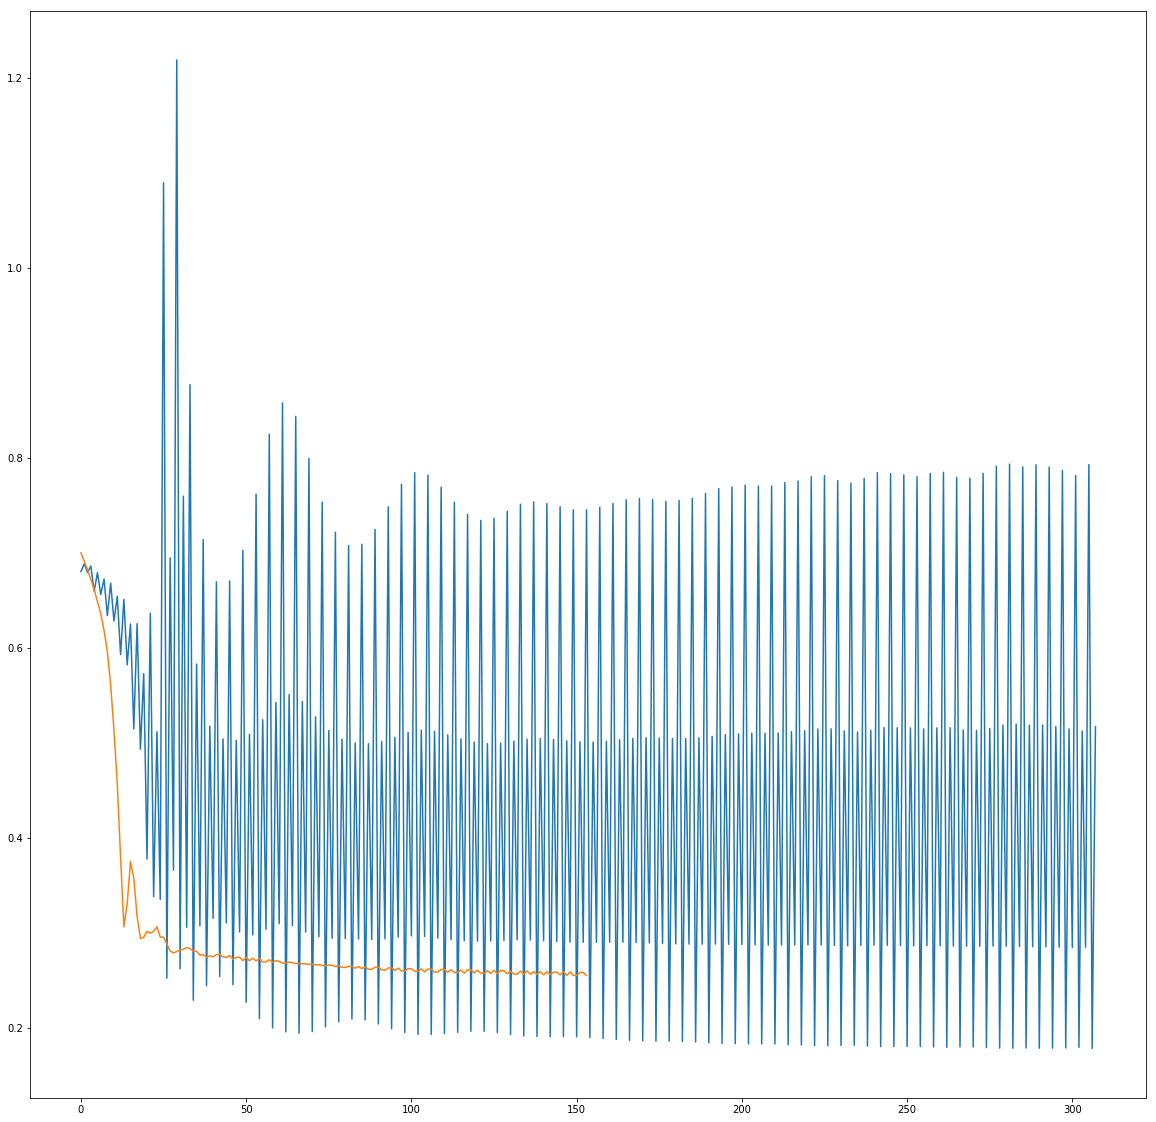

In [22]:
fig = plt.figure(figsize=(20,20))
plt.plot(val_epoch_loss)
plt.plot(epoch_loss)

plt.show()

In [23]:
avg_ep = [epoch_loss[x:x+2] for x in range(0, len(epoch_loss), 2)]
avg_val_ep = [val_epoch_loss[x:x+4] for x in range(0, len(val_epoch_loss), 4)]


for i in range(len(avg_ep)):
    avg_ep[i]=sum(avg_ep[i])/len(avg_ep[i])

for i in range(len(avg_val_ep)):
    avg_val_ep[i]=sum(avg_val_ep[i])/len(avg_val_ep[i])

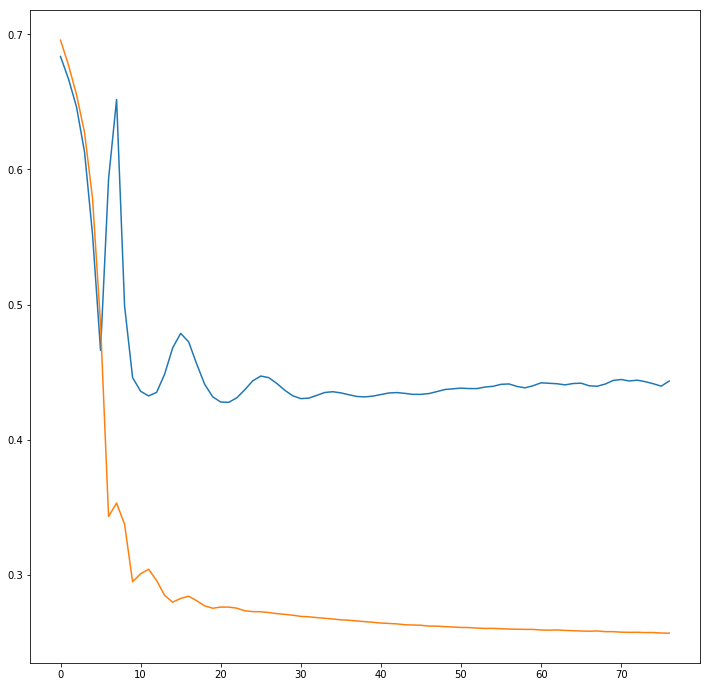

In [24]:
fig = plt.figure(figsize=(12, 12))
plt.plot(avg_val_ep)
plt.plot(avg_ep)

In [ ]:
%matplotlib inline

In [50]:
in_img = val_inputs[1]
in_img_avg = in_img[0]
in_img_corr = in_img[1]
tgt_img = val_targets[1]
out_data = val_outputs[1]
indicator  =  np.arange(out_data.shape[1]).reshape([1, -1, 1, 1])
np.sum(out_data*indicator, axis=1)
x = np.exp(out_data)
res = x/x.sum(1)

pos = np.argmax(res, axis=1)


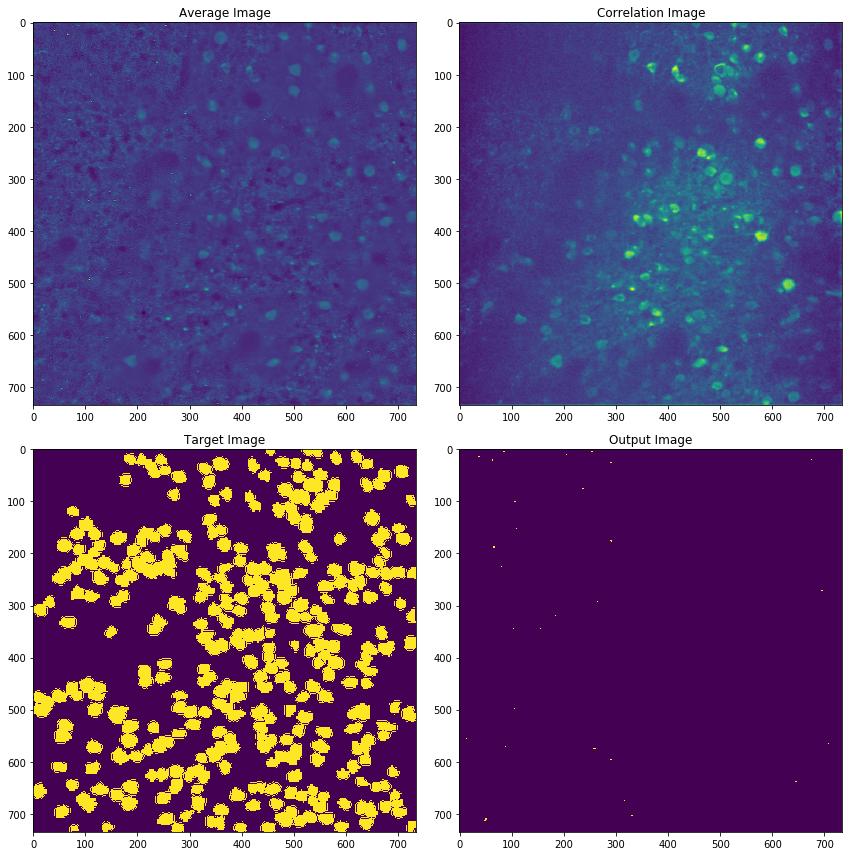

In [51]:
%matplotlib inline
plt.figure()

plt.subplots(figsize=(12,12))

avg = plt.subplot(221)
corr = plt.subplot(222)
tgt = plt.subplot(223)
out = plt.subplot(224)

avg.title.set_text("Average Image")
corr.title.set_text("Correlation Image")
tgt.title.set_text("Target Image")
out.title.set_text("Output Image")

avg.imshow(in_img_avg)
corr.imshow(in_img_corr)
tgt.imshow(tgt_img)
out.imshow(pos.squeeze())



plt.tight_layout()

In [28]:
train_outputs[0].max()

-0.62302512

In [27]:
pos.max()

1

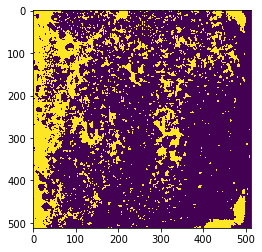

In [43]:
test = train_outputs[1]

indicator  =  np.arange(test.shape[1]).reshape([1, -1, 1, 1])
np.sum(test*indicator, axis=1)
x = np.exp(test)
res = x/x.sum(1)
pos = np.argmax(res, axis=1)

plt.imshow(pos.squeeze())